In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib.font_manager as fm
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우

plt.rc('axes', unicode_minus=False)  # 마이너스 깨짐 방지

In [148]:
df = pd.read_csv('./data/merge_data.csv')
df.head(2)

,nickname,world_name,character_class,character_level,character_exp_rate,character_date_create,dojang_best_floor,dojang_best_time,popularity,최소 스탯공격력,...,상태이상 추가 데미지,무기 숙련도,추가 경험치 획득,공격력,마력,전투력,소환수 지속시간 증가,force_sum,force_mean,force_min
0,아델,스카니아,아델,292,47.568,2020-01-16T00:00+09:00,99,896,8778,373904068,...,14.0,90,195.0,19129,4232,1352790435,10,2080.0,160.0,100.0
1,흡혈,스카니아,데몬어벤져,285,70.911,2022-03-30T00:00+09:00,85,884,595,271680490,...,14.0,90,59.0,14009,3710,1184547868,10,1950.0,150.0,0.0


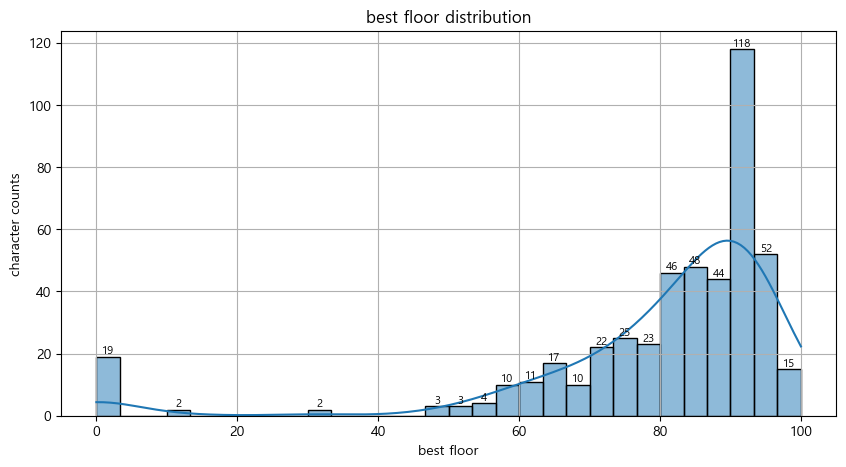

In [149]:
# 도장 최고층수 기본 분포 확인
plt.figure(figsize=(10,5))
ax = sns.histplot(df['dojang_best_floor'], bins=30, kde=True)

# 각 bar에 캐릭터 수 표시
for i in ax.patches:
    count = int(i.get_height())
    if count > 0 :
        ax.annotate(f'{count}', (i.get_x() + i.get_width() / 2, count),
                    ha='center', va='bottom', fontsize=8, rotation=0)
        
plt.title('best floor distribution')
plt.xlabel('best floor')
plt.ylabel('character counts')
plt.grid(True)
plt.show()

In [150]:
# 직업별 도장 최고층수 분포

# 직업별 평균 도장 최고층수 계산 후 시각화

mean_floor_by_class = (
    df.groupby('character_class')['dojang_best_floor']
    .mean()
    .sort_values(ascending=False)
)

# 상위 10개 하위 10개 직업을 시각화 해보기

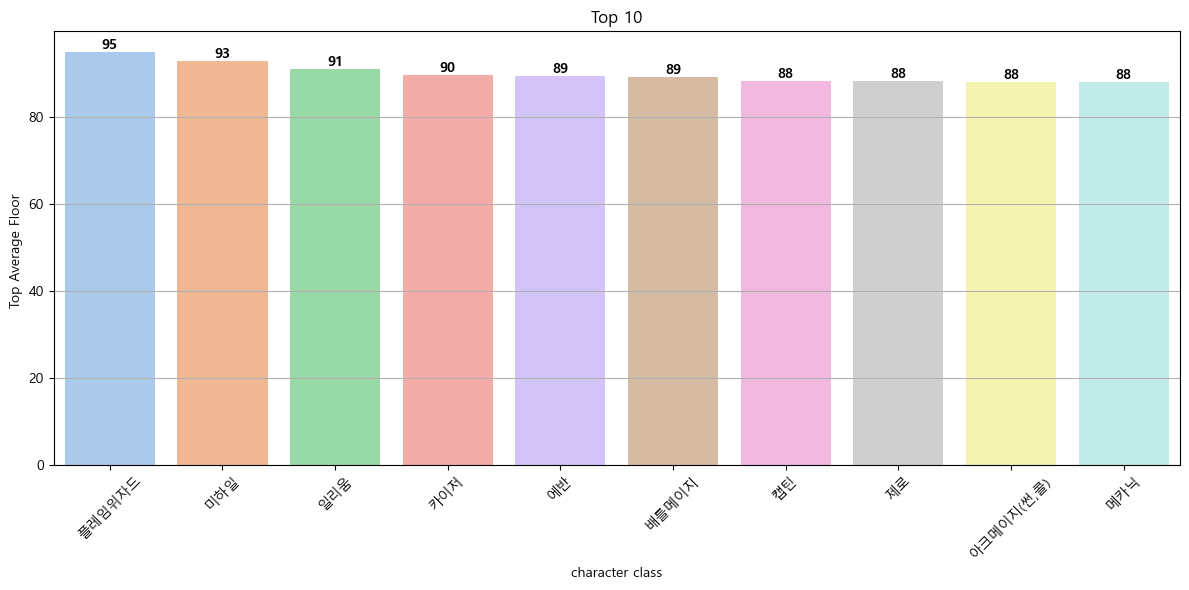

In [151]:
# 우선 상위 10개
palette = sns.color_palette("pastel")
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_floor_by_class.head(10).index, y=mean_floor_by_class.head(10).values, palette=palette)

for p in ax.patches:
    value = int(round(p.get_height()))
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Top 10')
plt.xlabel('character class')
plt.ylabel('Top Average Floor ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

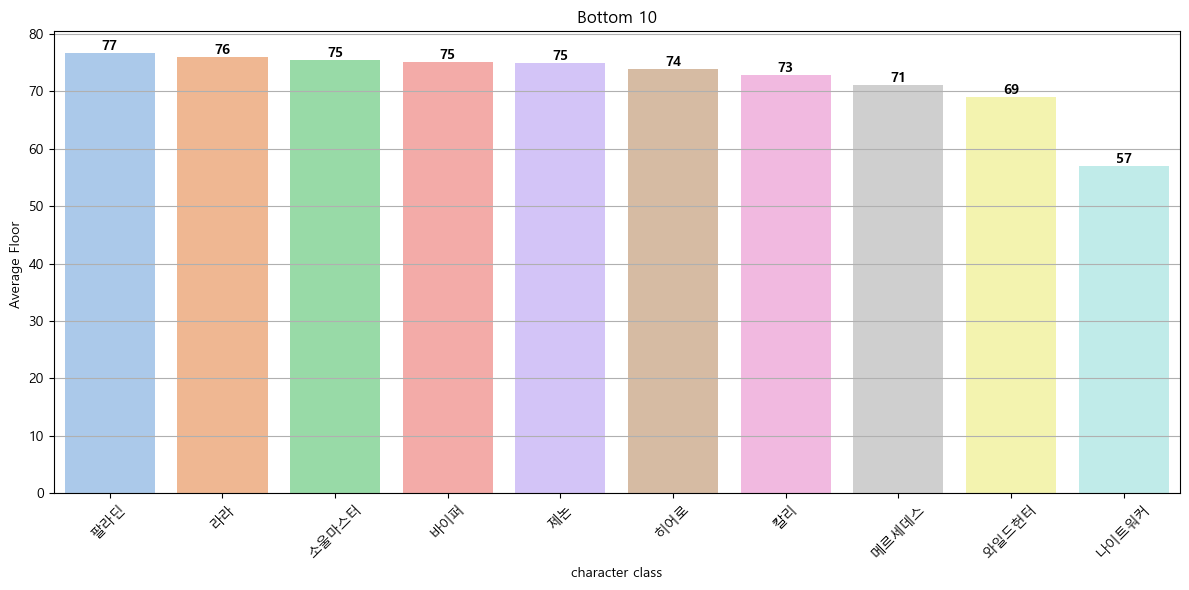

In [152]:
# 하위 10개 직업
# 4번 라인 head만 tail로 바꿔주면 끝

palette = sns.color_palette("pastel")
plt.figure(figsize=(12,6))
ax = sns.barplot(x=mean_floor_by_class.tail(10).index, y=mean_floor_by_class.tail(10).values, palette=palette)

for p in ax.patches:
    value = int(round(p.get_height()))
    ax.annotate(f'{value}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

plt.title('Bottom 10')
plt.xlabel('character class')
plt.ylabel('Average Floor ')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [153]:
df = df.drop(['character_date_create','nickname','world_name'], axis=1)
len(df['character_class'].value_counts())

44

In [154]:
# 우선 직업이 무려 44개나 됨 이걸 이후에 머신러닝 feature로 활용하기 위한 작업이 필요함
# 더미변수로 작업할 경우 컬럼이 44개나 더 생기는데, 이는 과적합을 발생시킬 위험이 존재
# 따리서 label encoding을 통해 숫자로 변환한 후, object type으로 변경

# 1. 고유한 직업 리스트 먼저 추출
unique_classes = df['character_class'].drop_duplicates().sort_values().reset_index(drop=True)

# 2. LabelEncoder 적용
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
class_mapping = pd.DataFrame({
    'character_class': unique_classes,
    'character_class_encoded': le.fit_transform(unique_classes)
})

class_mapping.to_csv('./data/class_mapping.csv', index=False)

# 3. 이후 df에 인코딩 값 부여
df = df.merge(class_mapping, on='character_class', how='left')


In [155]:
# 캐릭터 직업(character_class)컬럼 지우기

df = df.drop('character_class',axis=1)

In [157]:
# Drop columns
# 스탠스 : 고윳값이 하나
# 점프력 : 고윳값이 하나
# AP 배분 능력치 : 자동배분임 도장 순위에는 STR, DEX, INT, LUK 을 중점적으로 보는게 좋을듯

In [158]:
# 위의 세가지(고윳값이 하나인 컬럼 제거)
df.drop(columns=['스탠스','점프력','AP 배분 STR', 'AP 배분 DEX', 'AP 배분 INT',
       'AP 배분 LUK', 'AP 배분 HP', 'AP 배분 MP'], inplace=True)

### 캐릭터 성장 관련 피처 분포 시각화 및 전처리

- character_level
- character_exp_rate
- popularity
- 스타포스
- 아케인포스
- 어센틱포스

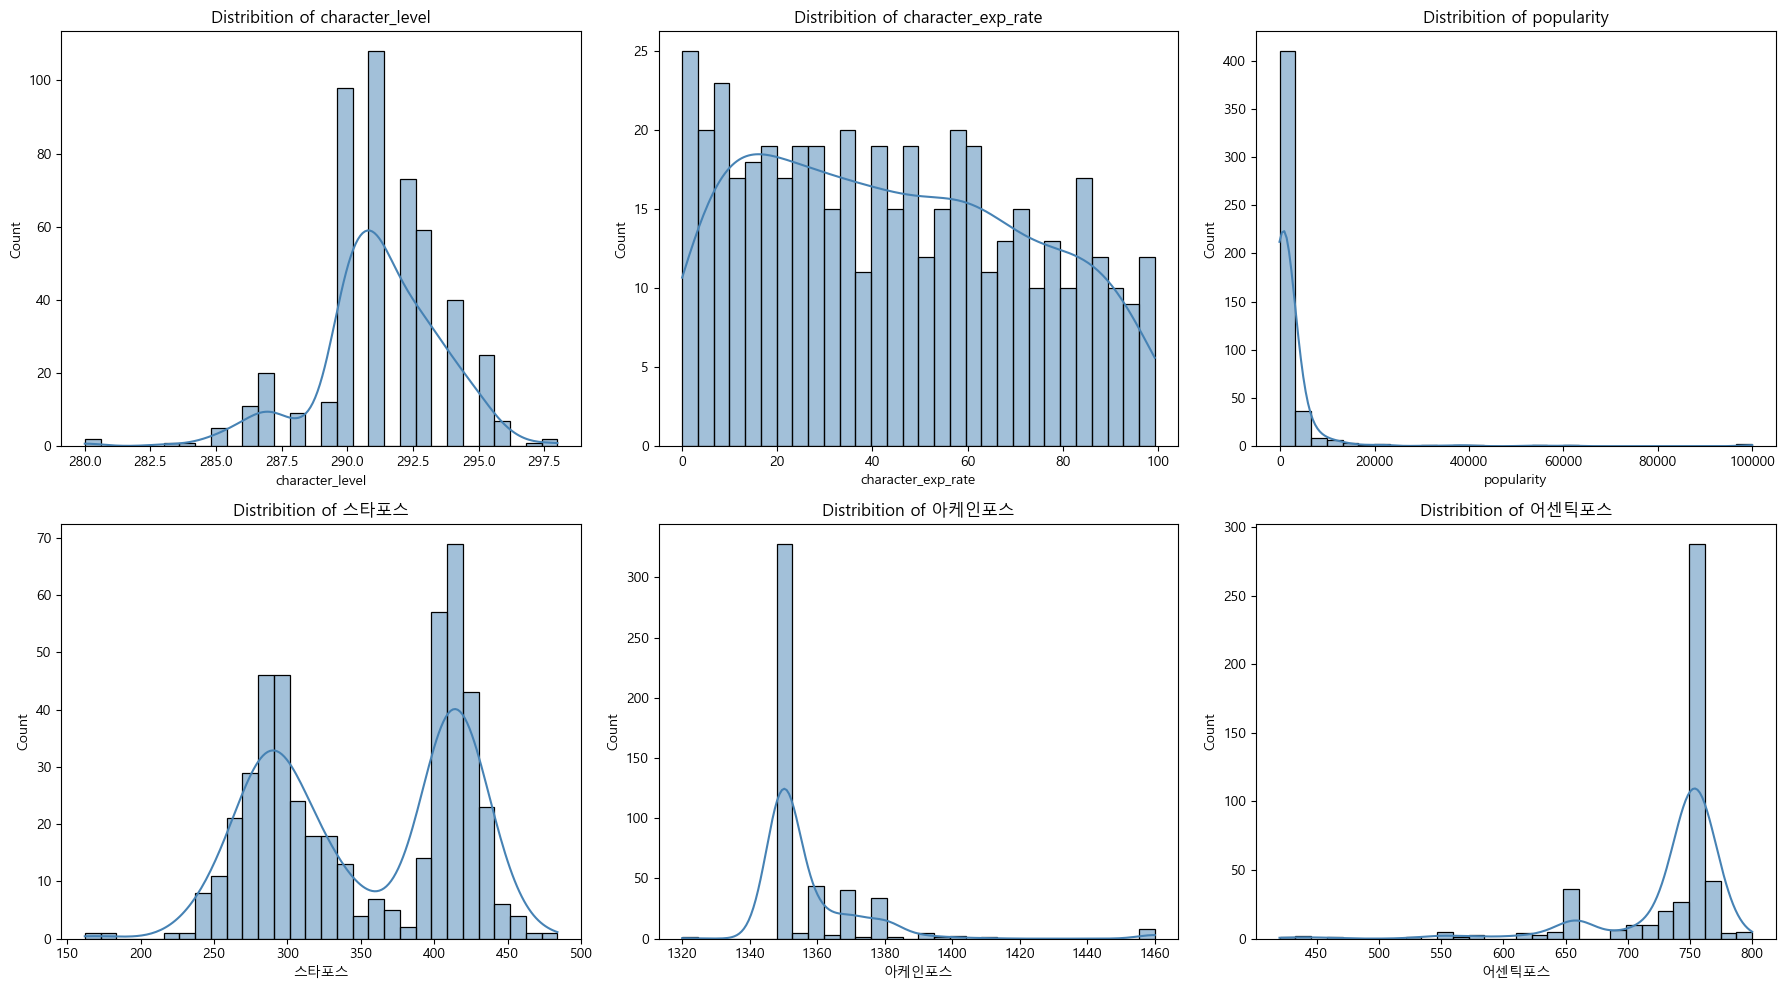

In [159]:
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False  

growth_feature = ['character_level','character_exp_rate','popularity'
                  ,'스타포스','아케인포스','어센틱포스']

fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()

for i, col in enumerate(growth_feature):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='steelblue')
    axes[i].set_title(f'Distribition of {col}', fontsize=12)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

1. character_level
    - 분포 : 대~체로 정규분포스럽(?)긴 함
    - 이상치는 없음(있을수가 없긴함 랭커들을 크롤링해서 한것이니)

2. character_exp_rate
    - 분포 :  전 범위에 고르게 분포
    - 0~1 로 정규화

3. Popularity
    - 분포 : 극단적인 이상치가 존재함. - 물론 인기도의 척도는 유명 방송인이 압도적일것이라 어느정도 예상은 함
    - 과연 인기도가 무릉도장 등수에 영향을 미치는가...?에 대해서는 조금 궁금하긴함
    - <span style="color:orange">**통계분석만을 진행해볼 것(spearmanr, pearsonr)**</span>
    - <span style="color:orange">**ML input feature 에선 제거**</span>

4. 스타포스
    - 분포 : 봉우리가 두개임 재밋게 생김(두개의 집단으로 나뉨)
    - 제법 유의미한 데이터가 될 것 같은 느낌임
    - 그대로 사용해도 괜찮을것 같음

5. 아케인포스
    - 스읍....아무래도 고랩 유저다 보면 아케인포스 관리는 꾸준할테니,,
    - 유의미해 보이진 않음
    - <span style="color:orange">**제거**</span>

6. 어센틱 포스
    - 얘도 <span style="color:orange">**제거**</span>

In [160]:
# popularity 가 과연 target으로 두고 있는 dojang_best_floor랑 어떤 관계에 있는가에 대하여

from scipy.stats import spearmanr, pearsonr

tmp_df = df[['popularity', 'dojang_best_floor']].dropna()

# Spearman
spearman_corr, spearman_p = spearmanr(tmp_df['popularity'], tmp_df['dojang_best_floor'])

# Pearson
pearson_corr, pearson_p = pearsonr(tmp_df['popularity'], tmp_df['dojang_best_floor'])

print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

Spearman correlation: 0.2131, p-value: 0.0000
Pearson correlation: -0.0539, p-value: 0.2416


- 결과가 뭔가 좀 애매한것이...(물론 유의미한건 아님 제거해도 무방하긴함) 인기도 자체가 최고층수에 대해서는 의미가 아예 없지는 않다고 해석됨
- 물론 목적으로 두고있는 도장층수 예측에는 활용은 안할듯 하지만, 인기도가 도장 층수에 대해 후천적으로 작용하는 부분은 있다고도 할 수 있을듯.

In [161]:
# 1. character_exp_rate : 0~1 비율로 정규화
df['character_exp_rate'] = df['character_exp_rate']/100

# 2. 아케인 어센틱 제거
df.drop(columns=['아케인포스','어센틱포스','popularity'], inplace=True)

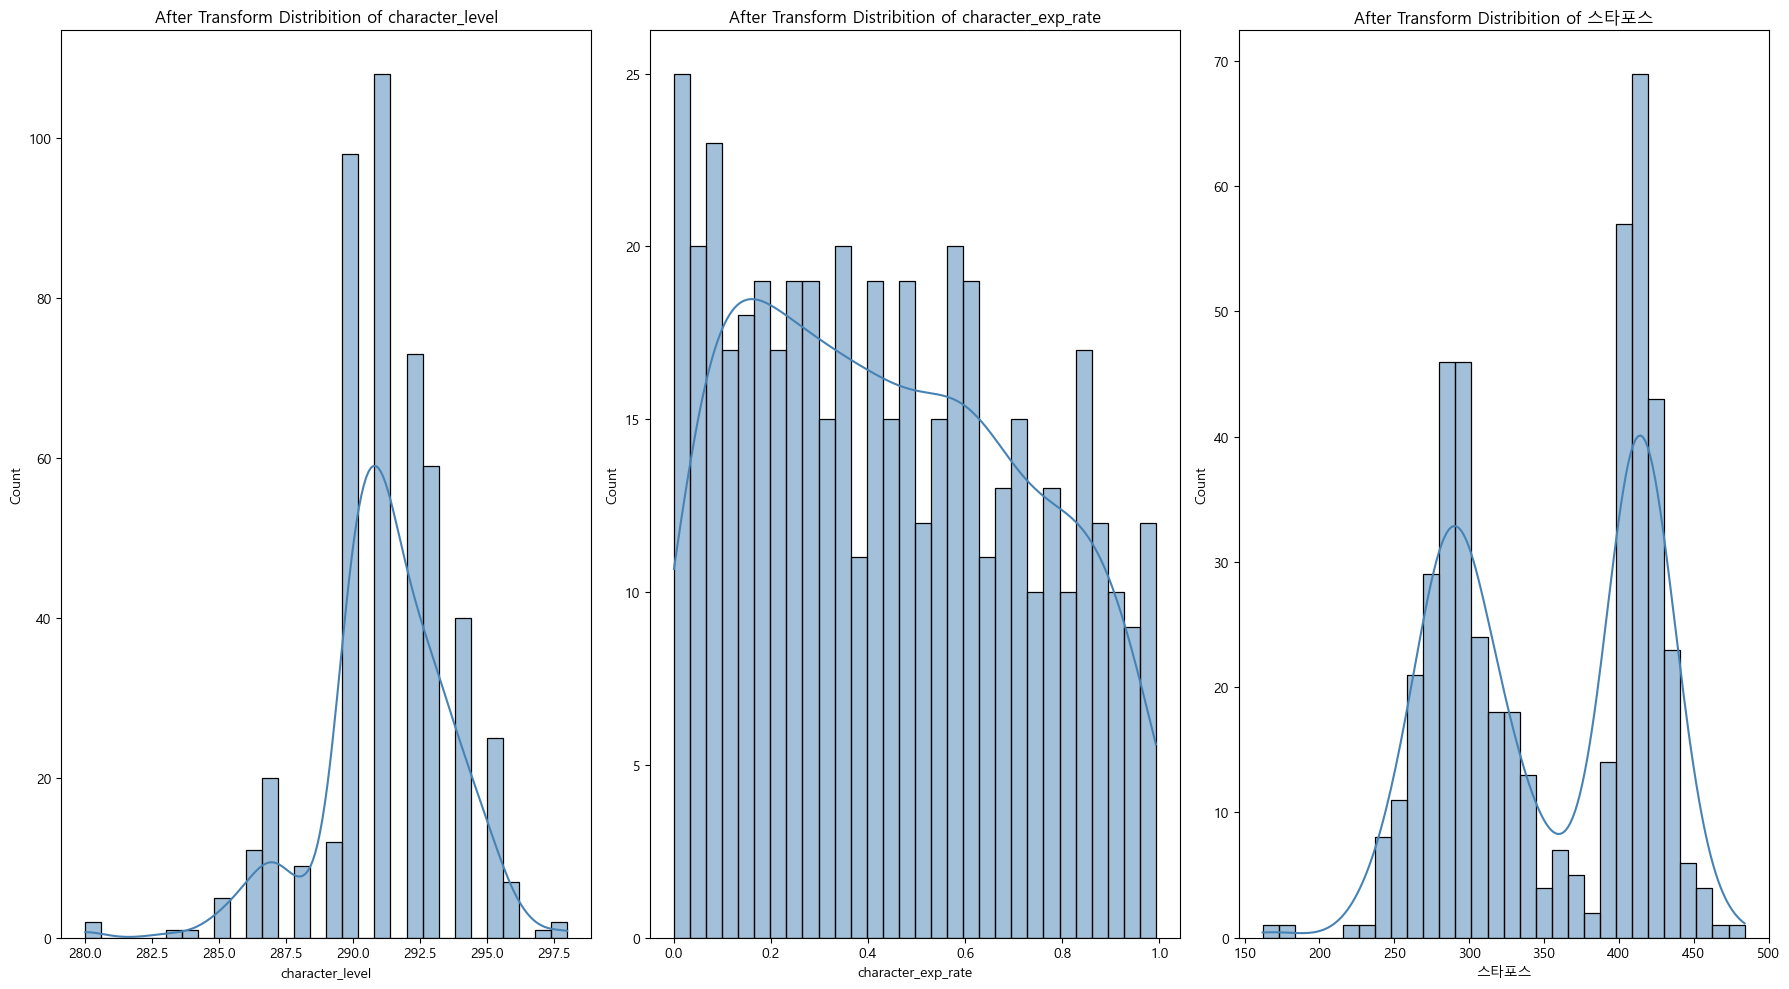

In [162]:
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False  

growth_feature = ['character_level','character_exp_rate','스타포스']

fig, axes = plt.subplots(1, 3, figsize=(18,10))
axes = axes.flatten()

for i, col in enumerate(growth_feature):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='steelblue')
    axes[i].set_title(f'After Transform Distribition of {col}', fontsize=12)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

### 공격력 관련 Features

1. 최소 스탯공격력
2. 최대 스탯공격력
3. 공격력
4. 마력
5. 전투력

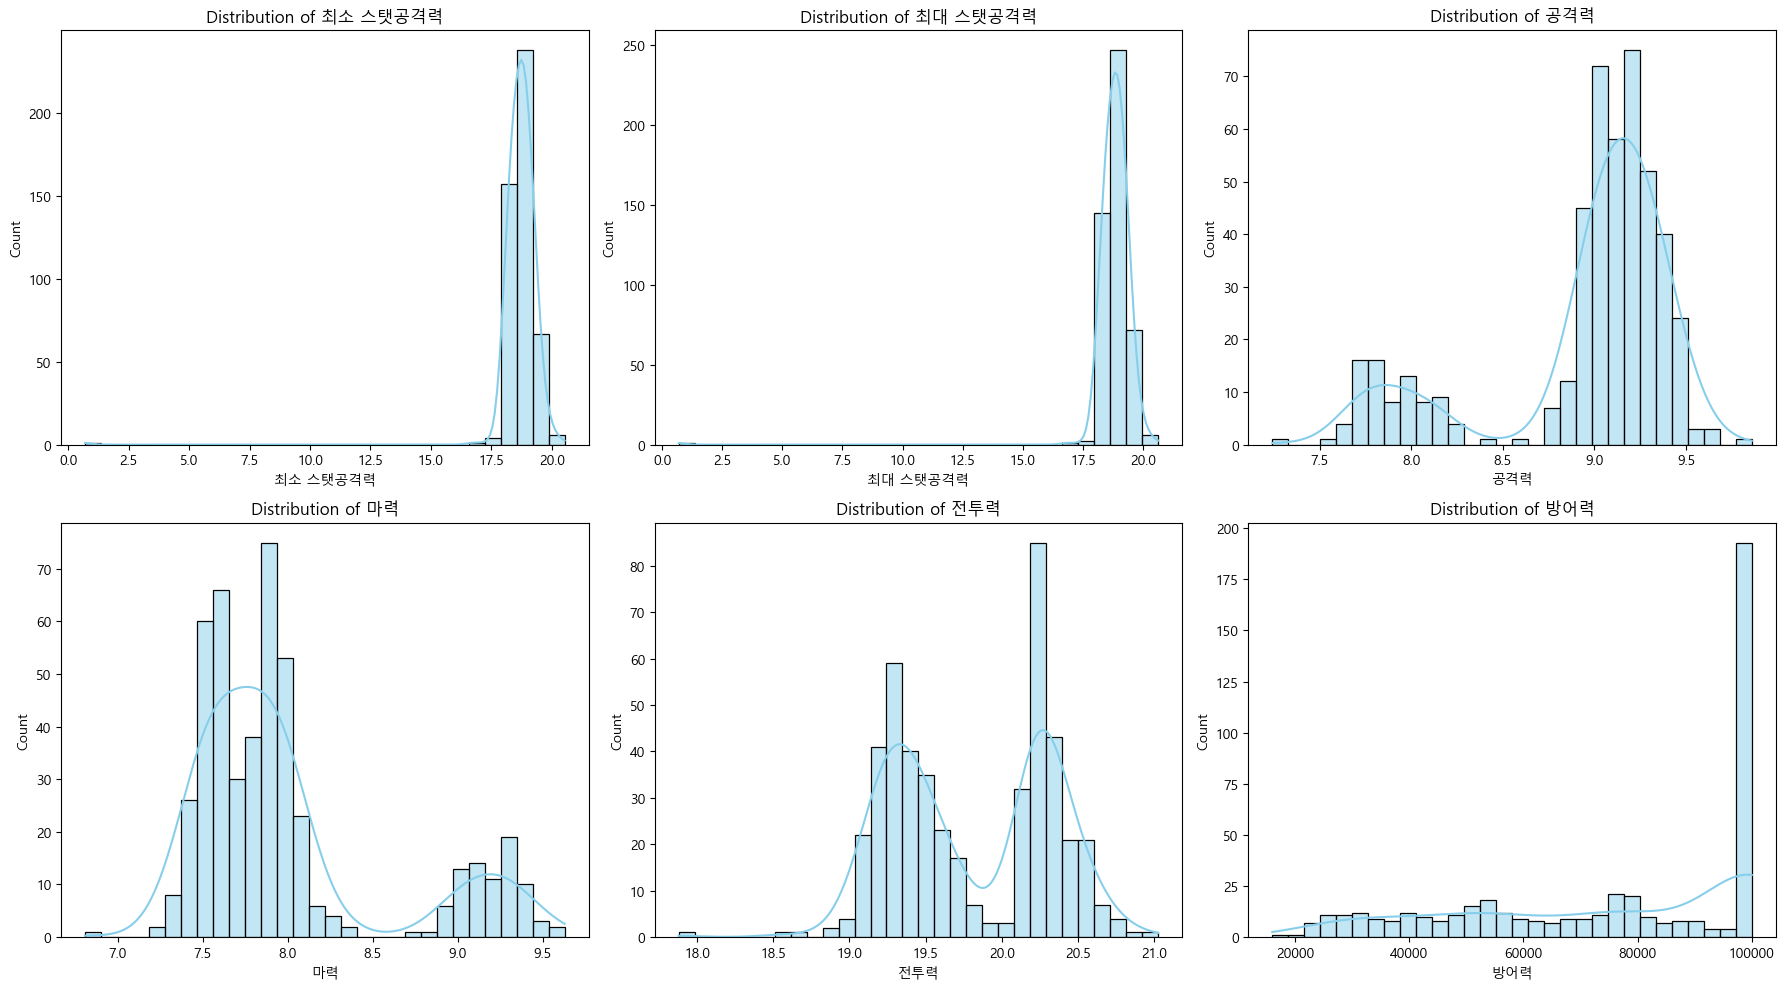

In [180]:
attack_cols = ['최소 스탯공격력','최대 스탯공격력','공격력','마력','전투력','방어력']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(attack_cols):
    sns.histplot(df[col], kde = True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

- 그림이 이전 분석 컬럼보단 확실히 이쁨(제법 정규성을 보이는듯한 느낌)

- 다섯개의 컬럼 변환 방법
    - 최소 스탯공격력 -> 오른쪽 치우침 : log transform

    - 최대 스탯공격력 -> '최소 스탯공격력' 이랑 마찬가지

    - 공격력 : 그냥 냅둬도 될듯 이후 머신러닝 성능에 따라 정규화를 할지 고민

    - 마력 : 얘도 log 변환 (치움침이 강해서)
    
    - 전투력 : 얘는 억단위 스케일이라 log변환 꼭 해야함 ㅎㅎ

In [181]:
df['최소 스탯공격력'] = np.log1p(df['최소 스탯공격력'])
df['최대 스탯공격력'] = np.log1p(df['최대 스탯공격력'])
df['공격력'] = np.log1p(df['공격력'])
df['마력'] = np.log1p(df['마력'])
df['전투력'] = np.log1p(df['전투력'])
df['방어력'] = np.log1p(df['방어력'])

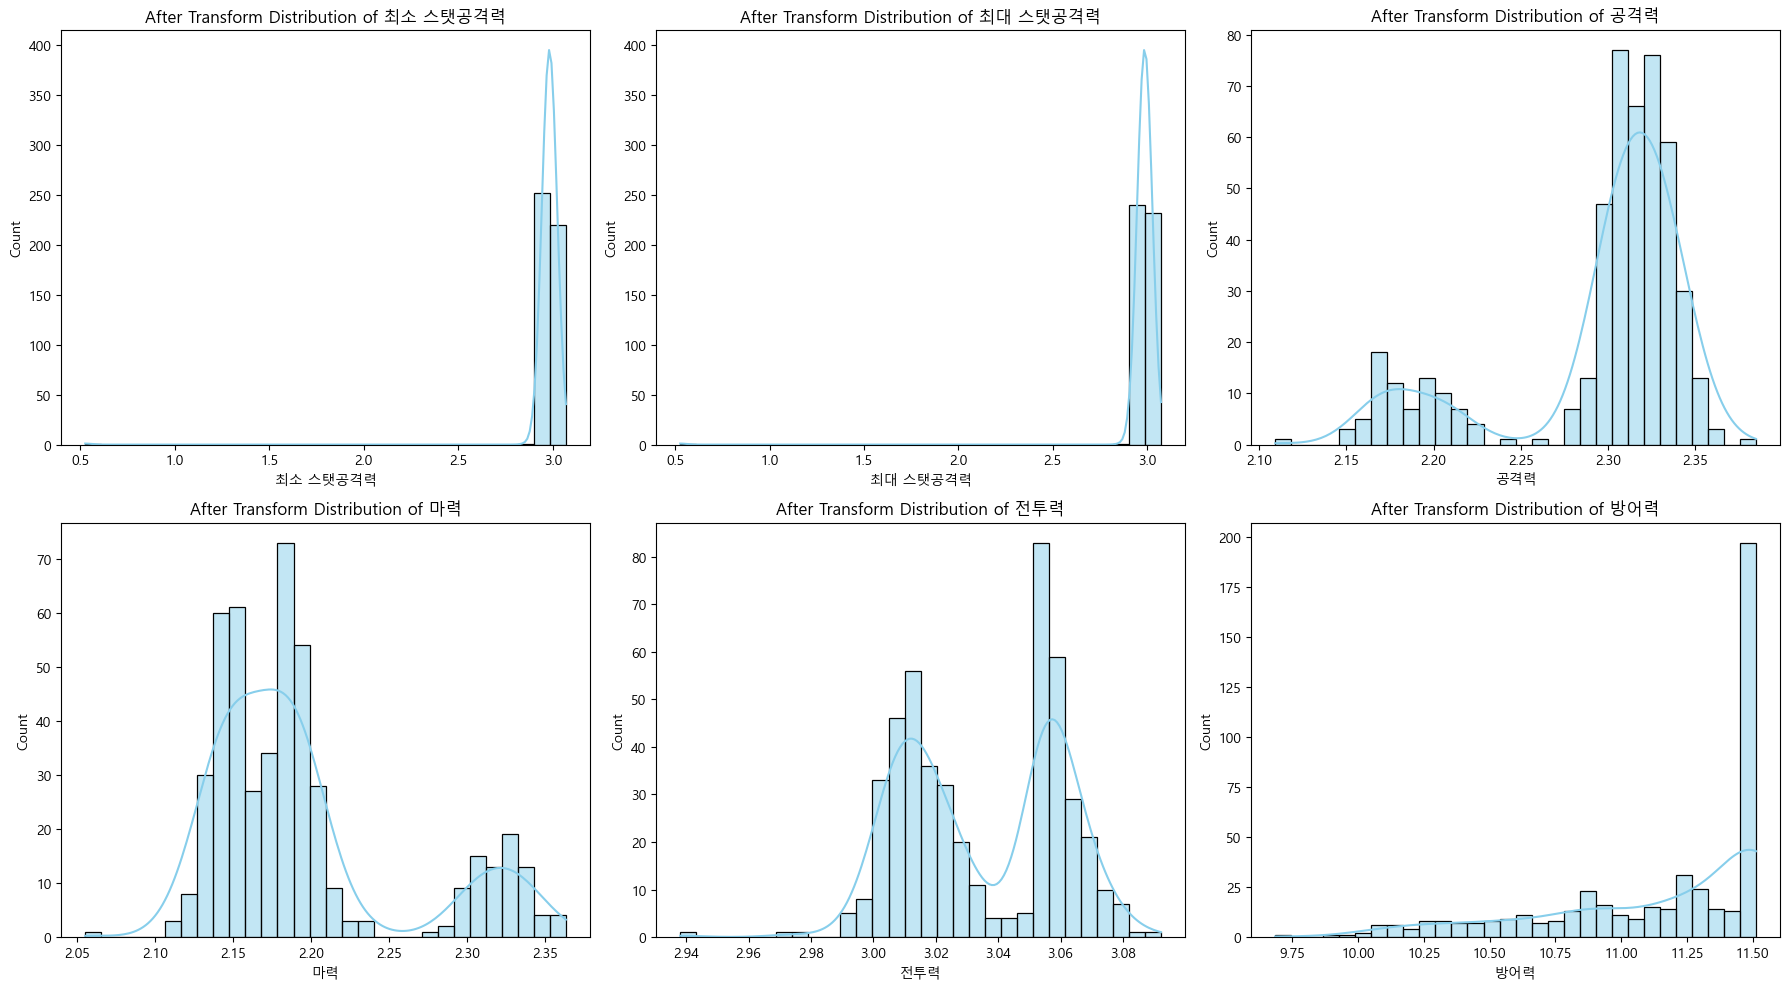

In [185]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(attack_cols):
    sns.histplot(df[col], kde = True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'After Transform Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

### 데미지 관련

1. 데미지
2. 보스 몬스터 데미지
3. 최종 데미지
4. 일반 몬스터 데미지

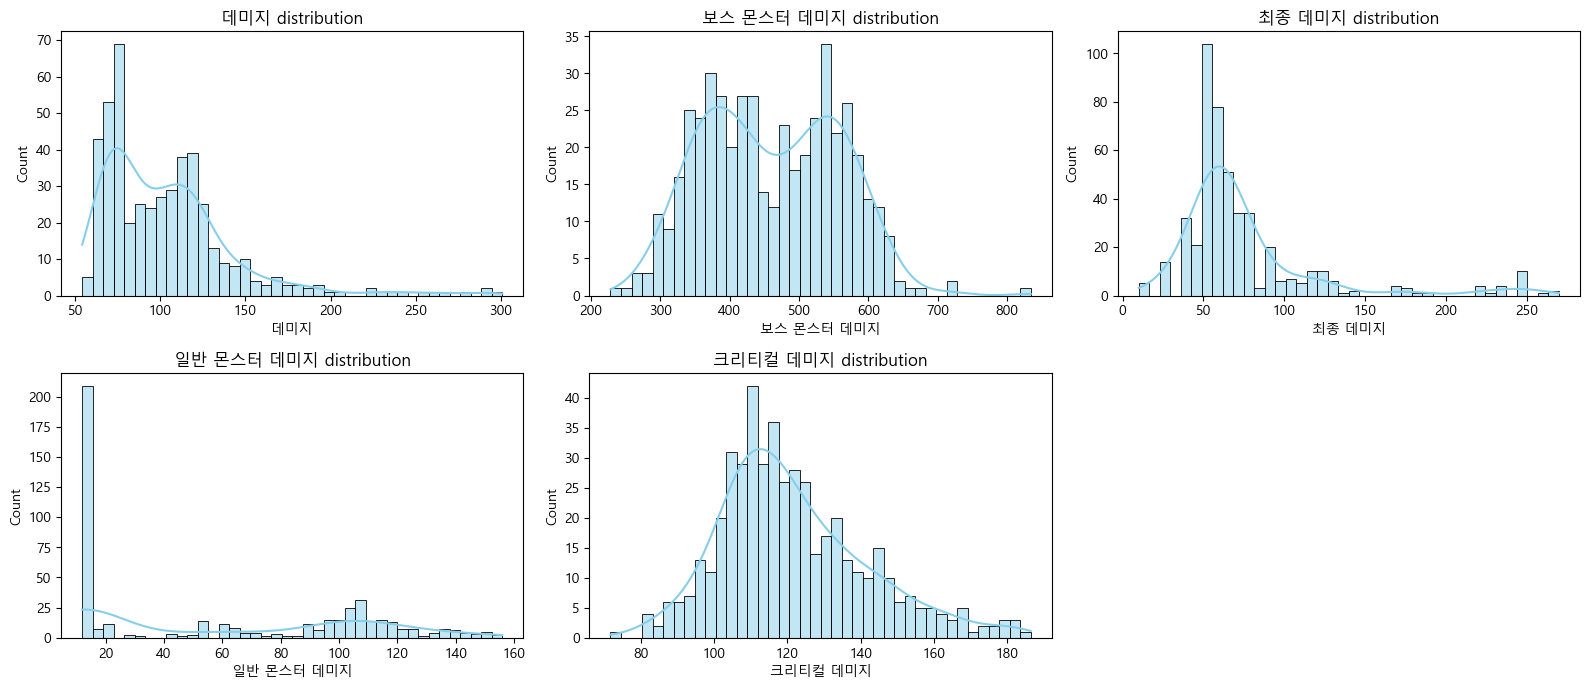

In [166]:
damage_cols = ['데미지','보스 몬스터 데미지','최종 데미지'
               ,'일반 몬스터 데미지','크리티컬 데미지']

plt.figure(figsize=(16,10))

for i, col in enumerate(damage_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(f'{col} distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [167]:
df[damage_cols]

# 분명 데미지는 조 단위일 것...조 단위겠지..
# feature engineering이 되어있는 데이터 이므로 변환은 하지 않겠음

,데미지,보스 몬스터 데미지,최종 데미지,일반 몬스터 데미지,크리티컬 데미지
0,101.0,475.0,67.31,12.0,126.55
1,93.0,499.0,39.15,12.0,110.90
2,73.0,428.0,10.00,132.0,114.15
3,92.0,411.0,74.76,129.0,120.90
4,93.0,625.0,53.95,12.0,119.55
...,...,...,...,...,...
469,69.0,386.0,62.19,103.0,101.10
470,85.0,554.0,53.95,12.0,110.35
471,72.0,535.0,89.00,12.0,122.10
472,72.0,568.0,61.77,12.0,117.70


### 버프/딜 관련

1. 방어율 무시
2. 크리티컬 확률
3. 상태이상 내성

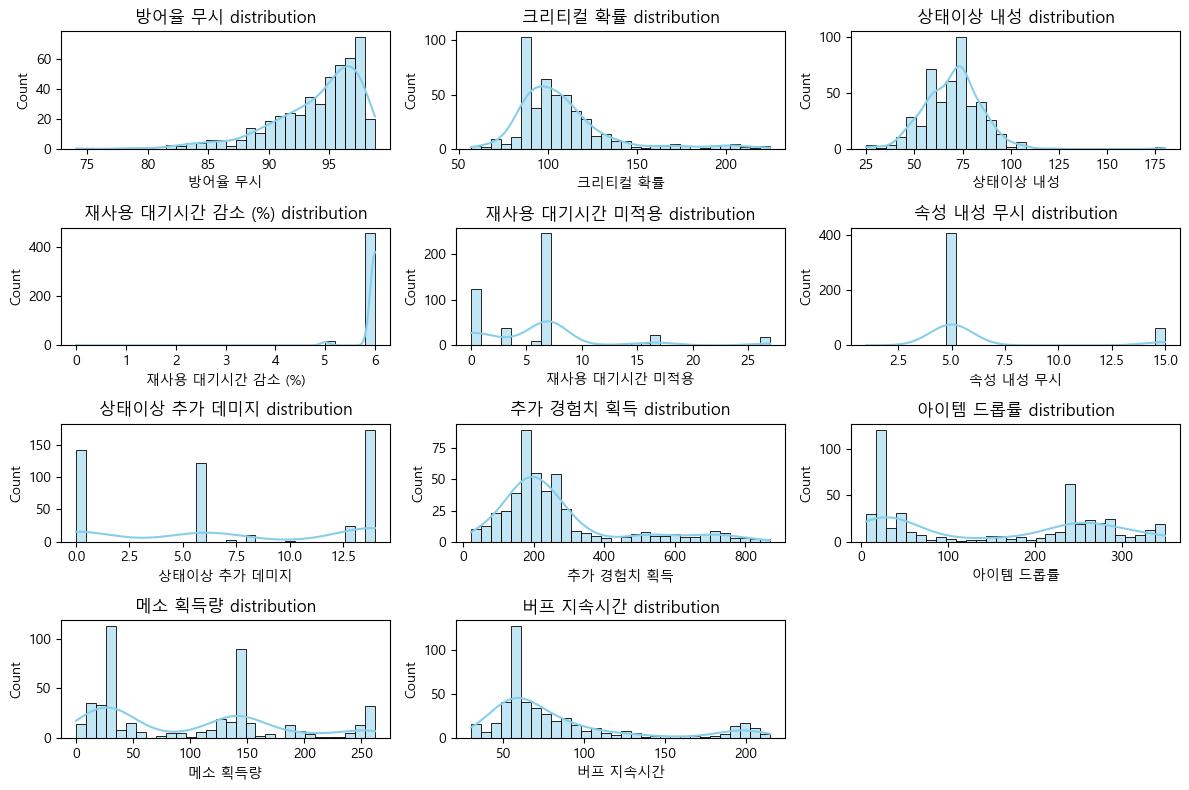

In [168]:
buff_cols = [
             '방어율 무시',
             '크리티컬 확률',
             '상태이상 내성',
             '재사용 대기시간 감소 (%)',
             '재사용 대기시간 미적용',
             '속성 내성 무시',
             '상태이상 추가 데미지',
             '추가 경험치 획득',
             '아이템 드롭률',
             '메소 획득량',
             '버프 지속시간'
             ]

plt.figure(figsize=(12,8))

for i, col in enumerate(buff_cols):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### 버프 관련 컬럼
- 얘네는 전체적으로 %로 나타난 컬럼들로 확인됨
- 변환을 x/100을 통해 진행

In [169]:
# buff_cols

for i in buff_cols:
    df[i] = df[i]/100

### Stat
1. STR
2. DEX
3. INT
4. LUK
5. HP
6. MP

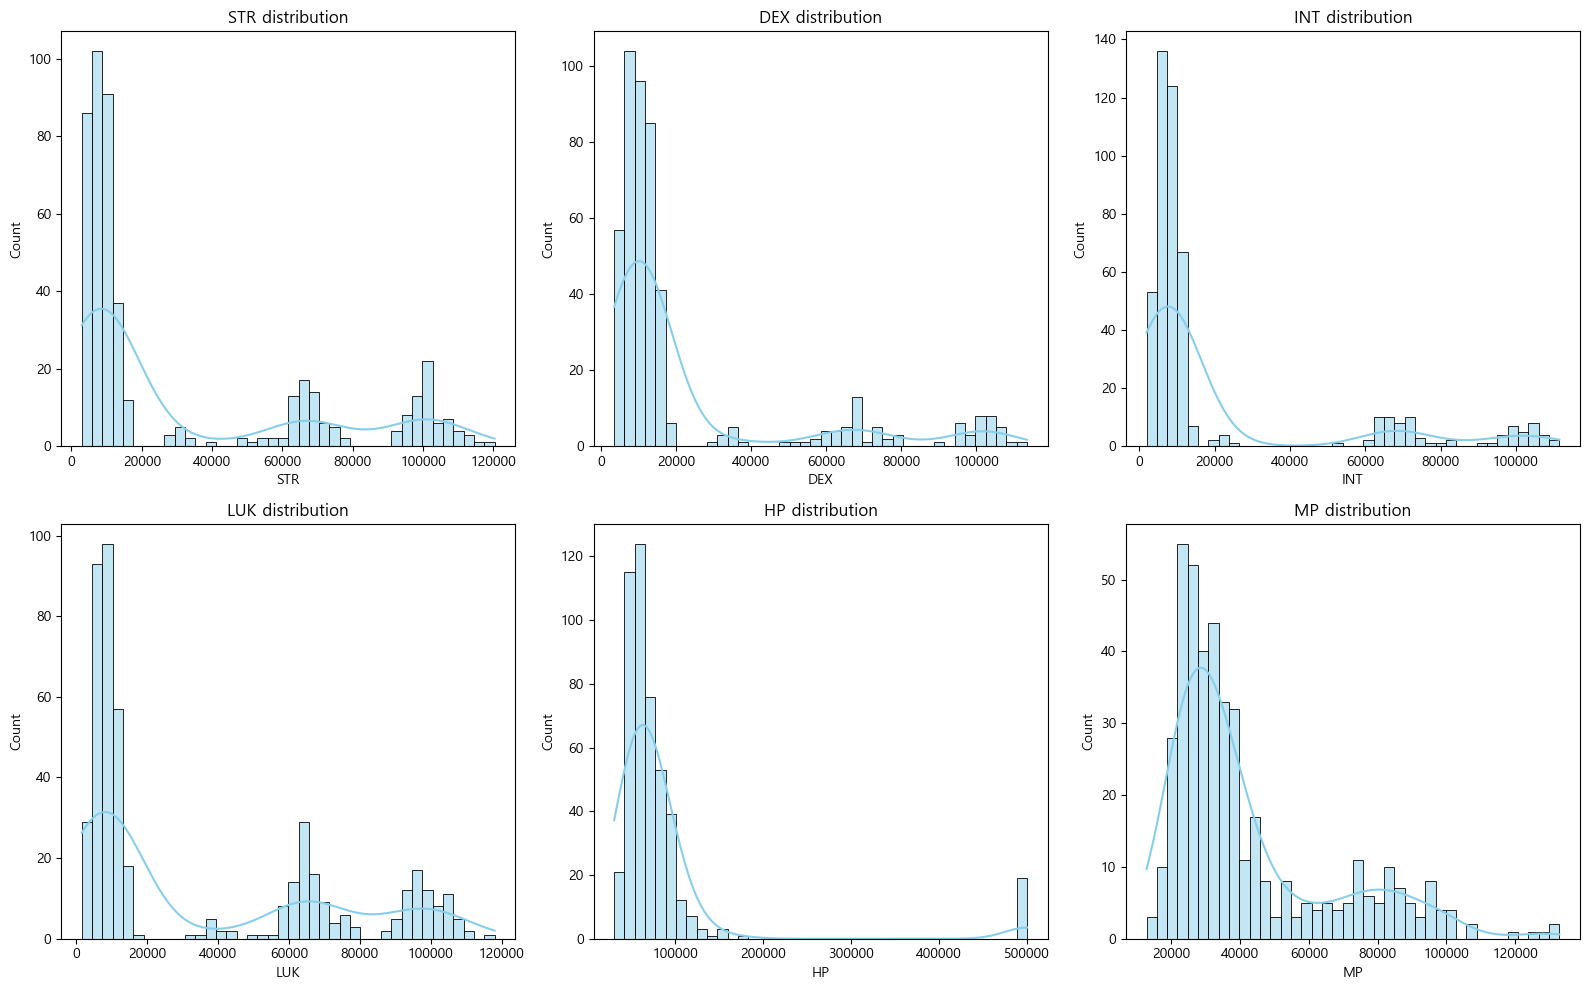

In [170]:
stat_cols = ['STR', 'DEX', 'INT', 'LUK', 'HP', 'MP']

plt.figure(figsize=(16,10))

for i, col in enumerate(stat_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(f'{col} distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [171]:
# stat_cols 로그 변환
for i in stat_cols:
    df[i] = np.log1p(df[i])

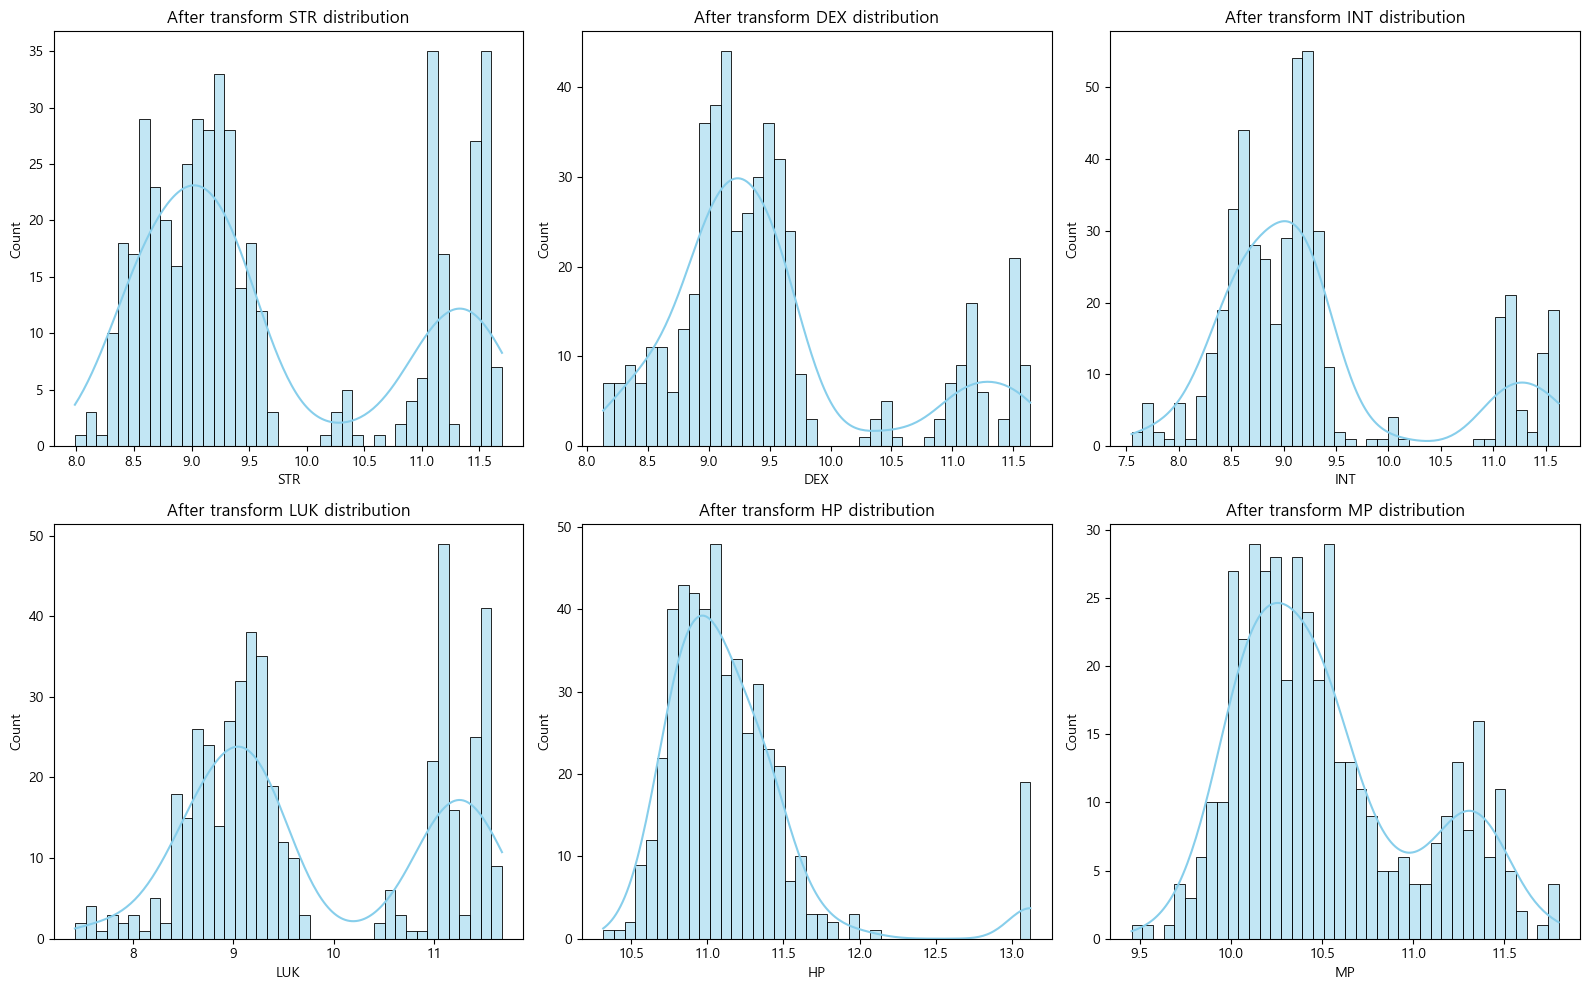

In [172]:
stat_cols = ['STR', 'DEX', 'INT', 'LUK', 'HP', 'MP']

plt.figure(figsize=(16,10))

for i, col in enumerate(stat_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(f'After transform {col} distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

### 시간관련 변수 변환 (초 -> 분)  
1. dojang_best_time x/60
2. 재사용 대기시간 감소(초) x/60
3. 소환수 지속시간 증가 %

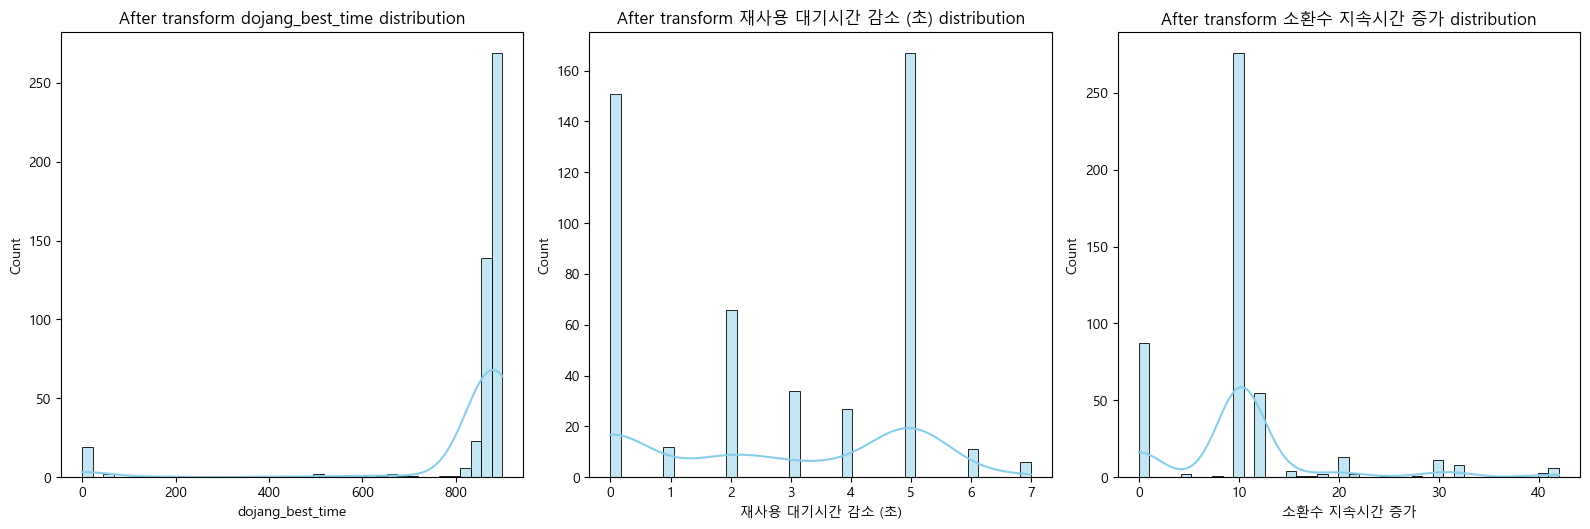

In [174]:
time_cols = ['dojang_best_time', '재사용 대기시간 감소 (초)', '소환수 지속시간 증가']


plt.figure(figsize=(16,10))

for i, col in enumerate(time_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(f'After transform {col} distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [177]:
time_cols =['dojang_best_time', '재사용 대기시간 감소 (초)', '소환수 지속시간 증가']

# df['dojang_best_time'] = df['dojang_best_time']/60
# df['재사용 대기시간 감소 (초)'] = df['재사용 대기시간 감소 (초)']/60
# df['소환수 지속시간 증가'] = df['소환수 지속시간 증가']/100

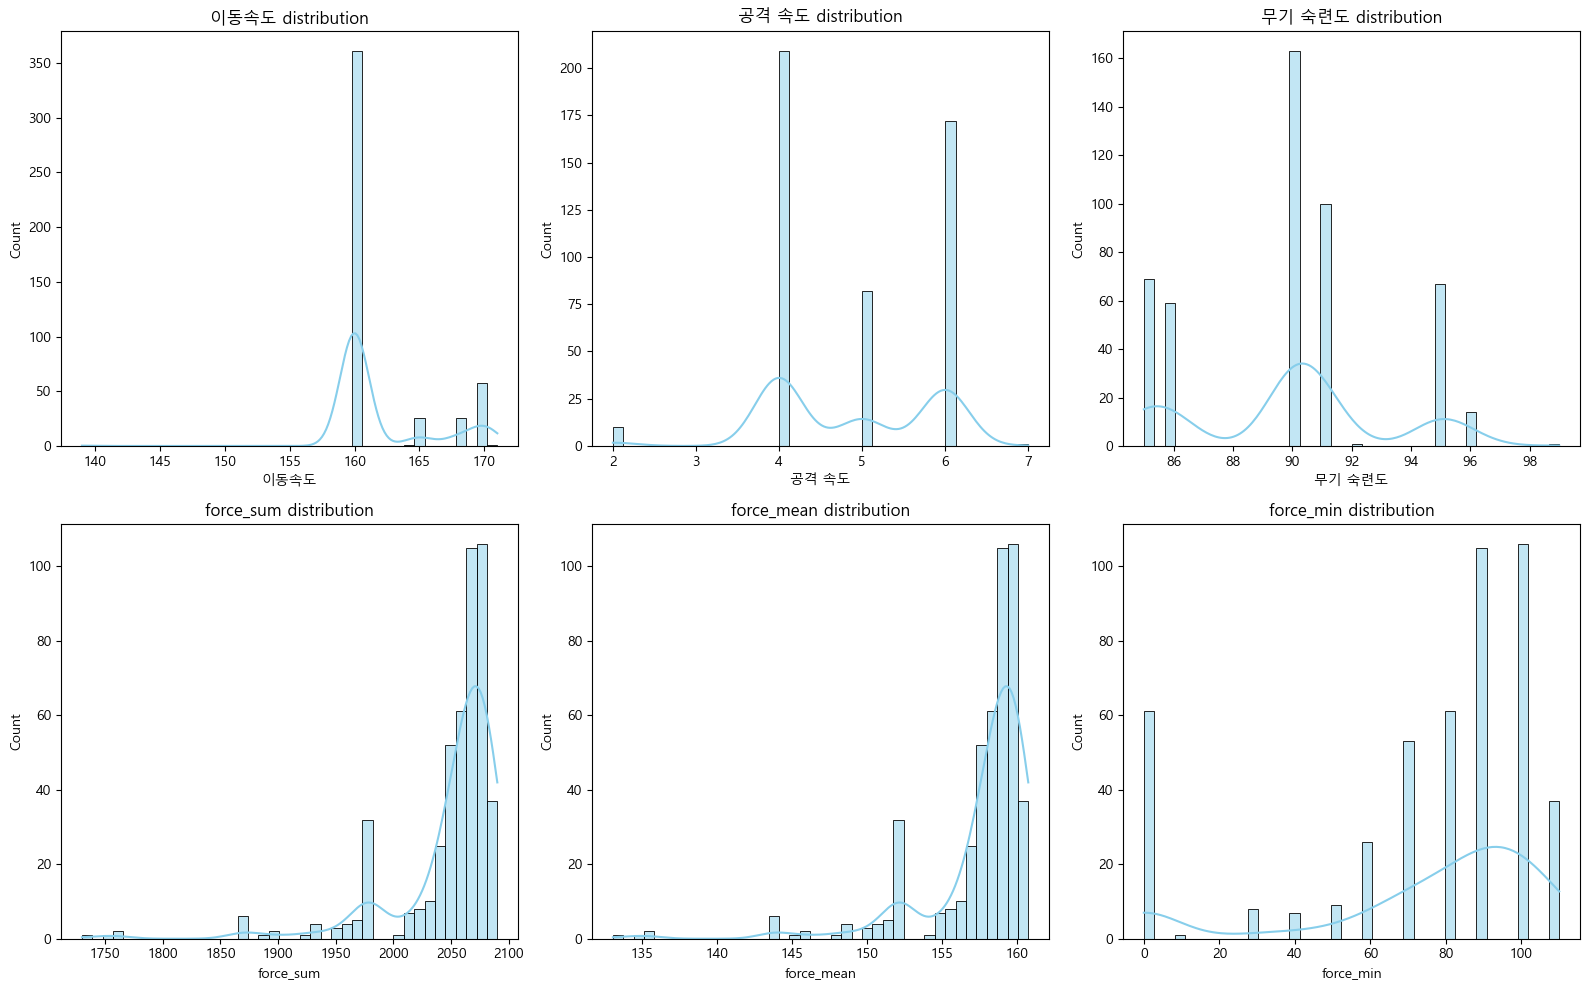

In [188]:
anothers = ['이동속도','공격 속도','무기 숙련도','force_sum', 'force_mean', 'force_min']

plt.figure(figsize=(16,10))

for i, col in enumerate(anothers):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], bins=40, kde=True, color='skyblue')
    plt.title(f'{col} distribution')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [193]:
df['무기 숙련도'].describe()

count    474.000000
mean      89.892405
std        3.260213
min       85.000000
25%       86.000000
50%       90.000000
75%       91.000000
max       99.000000
Name: 무기 숙련도, dtype: float64

### 그 외 나머지 컬럼들
1. 이동속도 : 스케일이 작고 범위도 좁음...일단은 그대로 사용
2. 공격속도 : 범주형의 느낌을 줌..의미 없어보임 - > **<span style="color:orange"> 제거 </span>**
3. 무기 숙련도 : 일단은 유지
4. force_sum : 제법 의미있는 누적분포의 형태가 보임
5. force_mean : 이미 평균값이기 때문에 그대로 사용
6. force_min : <span style="color:orange">**모델에 돌려본 이후 고려해볼 것**</span>

In [195]:
df.to_csv('./data/data_final.csv',index=False)